In [8]:
import warnings

# Ignore the warnings of statsmodels
warnings.filterwarnings("ignore", category=FutureWarning, module='statsmodels')
warnings.simplefilter("ignore")


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
data_1 = pd.read_csv('clean_data.csv')

In [19]:
from scipy.stats import ttest_ind # We will use this metric to measure the error of our model

from statsmodels.tsa.arima.model import ARIMA

# ARIMA 
We will apply the ARIMA method to the dataset to predict the last outputs

In [68]:

def estimator_arima(param, data= data_1, N_test = 70): 
    # This function is like a 'GridSearch' but manual
    
    arima = ARIMA(data['total_sales'], order = param)
    arima_result = arima.fit()
    # We use the metric of mean squared error to choose the best seasonal period
    result = ttest_ind(arima_result.forecast(N_test).values, data.iloc[-N_test:]['total_sales'].values)
    return np.abs(result.statistic), result.pvalue


In [59]:

import itertools

# We select the range where we want search the best
p_range = range(6, 12)  
d_range = range(1, 2)
q_range = range(7, 16)  

# Builds a list for every combination of p, d and q 
pdq = list(itertools.product(p_range, d_range, q_range))
best_t, best_param_1 = float("inf"), None
best_p, best_param_2 = float("inf"), None
# We select the best combination of pdq to our model 
for param in pdq:
    t, p_value = estimator_arima(param)
    if t < best_t:
        best_t = t
        best_param_1 = param
    if p_value < best_p:
        best_p = p_value
        best_param_2 = param
print('The least error we get is ', best_t,' and its period is',  best_param_1)
print('The least error we get is ', best_p,' and its period is',  best_param_2)

The least error we get is  0.21033836219539798  and its period is (8, 1, 14)
The least error we get is  1.4335287017509476e-08  and its period is (6, 1, 14)


In [73]:
# We train the dataset and get the results
def show_result(data = data_1, column = 'total_sales', parameter = (0, 0, 0), N_test = 70):
    train = data.iloc[:-N_test]
    test = data.iloc[-N_test:]
    train_idx = data.index <= train.index[-1]
    test_idx = data.index > train.index[-1]
    
    arima = ARIMA(train[column], order=(parameter))

    arima_result = arima.fit()

    data.loc[train_idx, 'AR(1)'] = arima_result.predict()
    data.loc[test_idx, 'AR(1)'] = arima_result.forecast(N_test).values

    fig, ax = plt.subplots(figsize=(15, 8))
    ax.plot(data[column], label='data')

    # plot the curve fitted on train set
    train_pred = arima_result.fittedvalues
    ax.plot(train.index, train_pred, color='green', label='fitted')

    # forecast the test set
    prediction_result = arima_result.get_forecast(N_test)
    conf_int = prediction_result.conf_int()
    lower, upper = conf_int['lower ' + column], conf_int['upper '+ column]
    forecast = prediction_result.predicted_mean
    ax.plot(test.index, forecast, label='forecast')
    ax.fill_between(test.index, \
                    lower, upper, \
                    color='red', alpha=0.3)
    ax.legend()




We can observe that there is an outlier that ARIMA is not able to predict

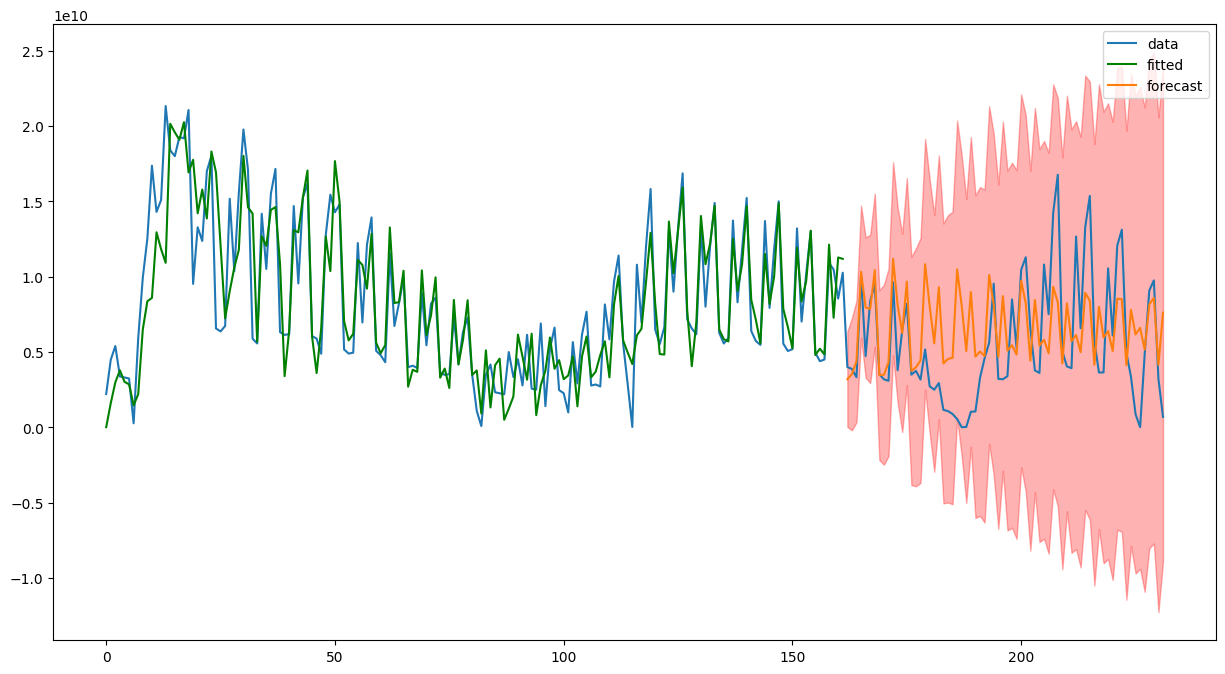

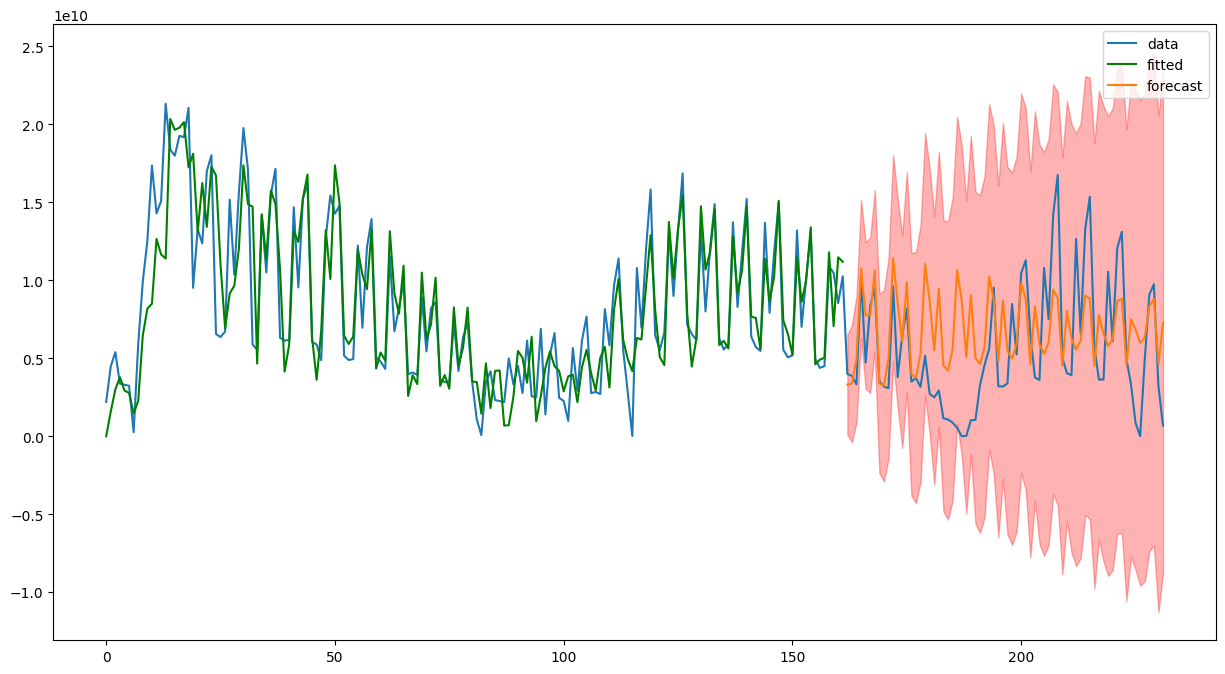

In [64]:
show_result(parameter = best_param_1)
show_result(parameter = best_param_2)

As we have a big error on the prediction we will shorten the dataset and in this new one with no outliers see if we can make a good prediction in the test set.

In [65]:
data_2 = data_1.copy()

In [66]:
data_2 = data_2.iloc[:-55]

In [75]:
# We select the range where we want search the best
p_range = range(8, 12)  
d_range = range(1, 2)
q_range = range(10, 20)  

# Builds a list for every combination of p, d and q 
pdq = list(itertools.product(p_range, d_range, q_range))
best_t, best_param_1 = float("inf"), None
best_p, best_param_2 = float("inf"), None
# We select the best combination of pdq to our model 
for param in pdq:
    t, p_value = estimator_arima(param, data = data_2, N_test = 50)
    if t < best_t:
        best_t = t
        best_param_1 = param
    if p_value < best_p:
        best_p = p_value
        best_param_2 = param
print('The least error we get is ', best_t,' and its period is',  best_param_1)
print('The least error we get is ', best_p,' and its period is',  best_param_2)

The least error we get is  0.23353929732372605  and its period is (11, 1, 15)
The least error we get is  4.6568369237290347e-07  and its period is (8, 1, 14)


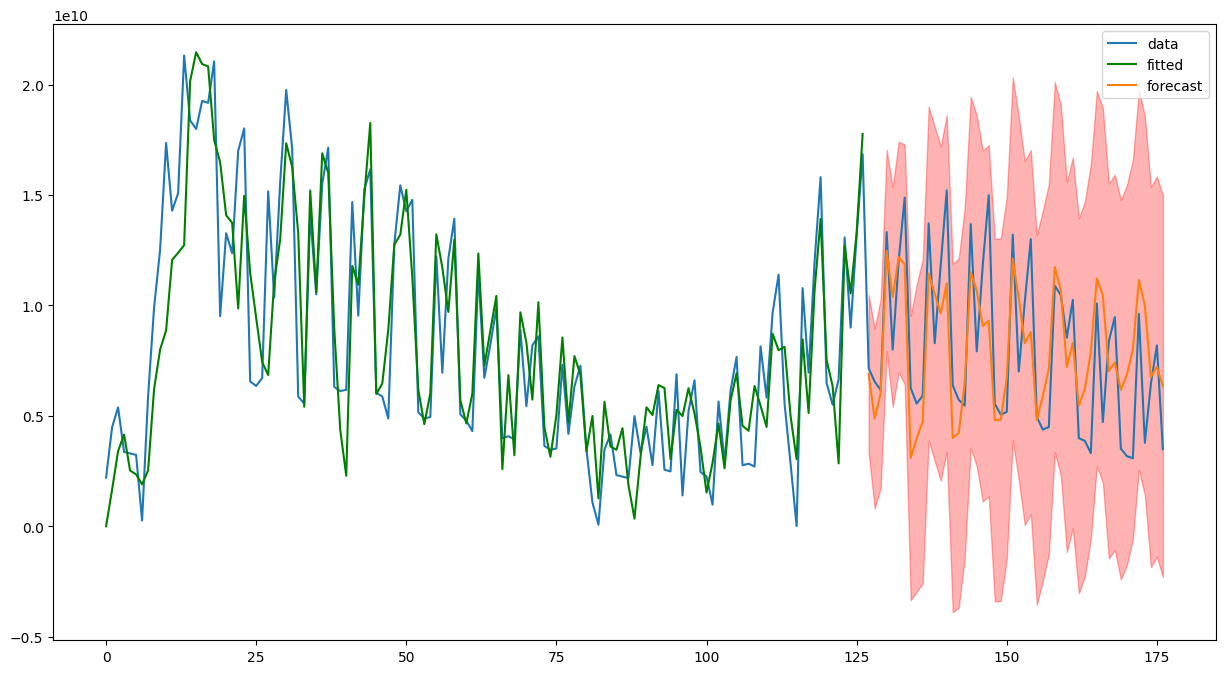

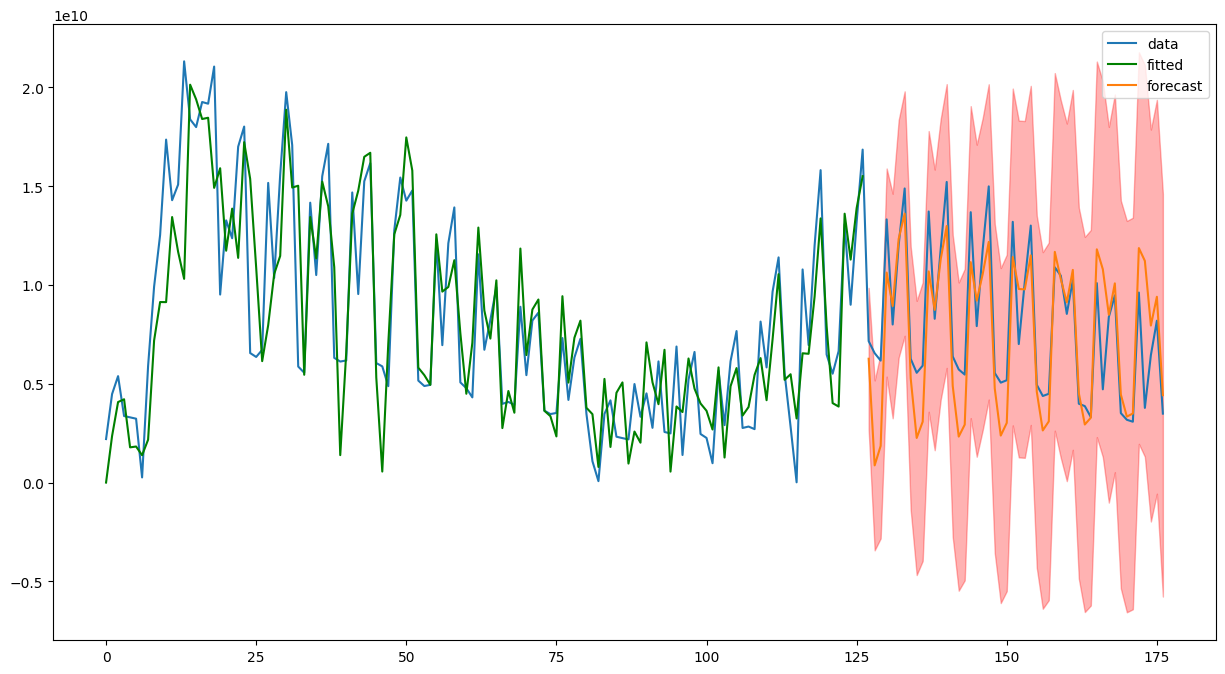

In [76]:
show_result(data = data_2, parameter = best_param_1, N_test = 50)
show_result(data = data_2, parameter = best_param_2, N_test = 50)

In [77]:
import pmdarima as pm

In [160]:
N_test = 70
train = data_1.iloc[:-N_test]
test = data_1.iloc[-N_test:]

In [190]:
model = pm.auto_arima(train['total_sales'],
                      trace=True,
                      suppress_warnings=True,
                      method = 'powell',
                      seasonal=True, m = 52, n_jobs = 4, max_p = 12, max_q = 10, 
                      start_p= 4, start_q = 4
                      )

Performing stepwise search to minimize aic
 ARIMA(4,1,4)(1,0,1)[52] intercept   : AIC=7533.496, Time=17.25 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=7623.073, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=7611.077, Time=1.66 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=7589.344, Time=1.55 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=7621.092, Time=0.02 sec
 ARIMA(4,1,4)(0,0,1)[52] intercept   : AIC=7541.570, Time=7.50 sec
 ARIMA(4,1,4)(1,0,0)[52] intercept   : AIC=7542.606, Time=8.02 sec
 ARIMA(4,1,4)(2,0,1)[52] intercept   : AIC=7533.823, Time=105.49 sec
 ARIMA(4,1,4)(1,0,2)[52] intercept   : AIC=7538.274, Time=70.01 sec
 ARIMA(4,1,4)(0,0,0)[52] intercept   : AIC=7537.851, Time=0.72 sec
 ARIMA(4,1,4)(0,0,2)[52] intercept   : AIC=7536.674, Time=60.33 sec
 ARIMA(4,1,4)(2,0,0)[52] intercept   : AIC=inf, Time=136.35 sec
 ARIMA(4,1,4)(2,0,2)[52] intercept   : AIC=7546.932, Time=57.34 sec
 ARIMA(3,1,4)(1,0,1)[52] intercept   : AIC=7554.170, Time=15.61 sec
 ARIMA(4,1,3)(1

In [191]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  162
Model:             SARIMAX(4, 1, 6)x(0, 0, [1], 52)   Log Likelihood               -3747.034
Date:                              Sun, 28 Apr 2024   AIC                           7518.067
Time:                                      21:52:45   BIC                           7555.044
Sample:                                           0   HQIC                          7533.082
                                              - 162                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4948      0.051     -9.724      0.000      -0.595      -0.395
ar.L2          0.3230      0.050      6.400      0.000       0.224       0.422
ar.L3         -0.4424      0.049     -8.989      0.000      -0.539      -0.346
ar.L4         -0.9293      0.043    -21.673      0.000      -1.013      -0.845
ma.L1          0.1523      0.096      1.588      0.112      -0.036       0.340
ma.L2         -0.9394      0.093    -10.155      0.000      -1.121      -0.758
ma.L3          0.2944      0.102      2.880      0.004       0.094       0.495
ma.L4          0.9476      0.114      8.279      0.000       0.723       1.172
ma.L5         -0.2210      0.098     -2.244      0.025      -0.414      -0.028
ma.L6         -0.3588      0.105     -3.418      0.001      -0.565      -0.153
ma.S.L52      -0.2715      0.125     -2.169      0.030      -0.517      -0.026
sigma2      9.153e+18        nan        nan        nan         nan         nan
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):                 7.68
Prob(Q):                              0.51   Prob(JB):                         0.02
Heteroskedasticity (H):               0.50   Skew:                            -0.28
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.53e+53. Standard errors may be unstable.
"""

In [192]:
test_pred, confint = model.predict(n_periods=N_test, return_conf_int=True)


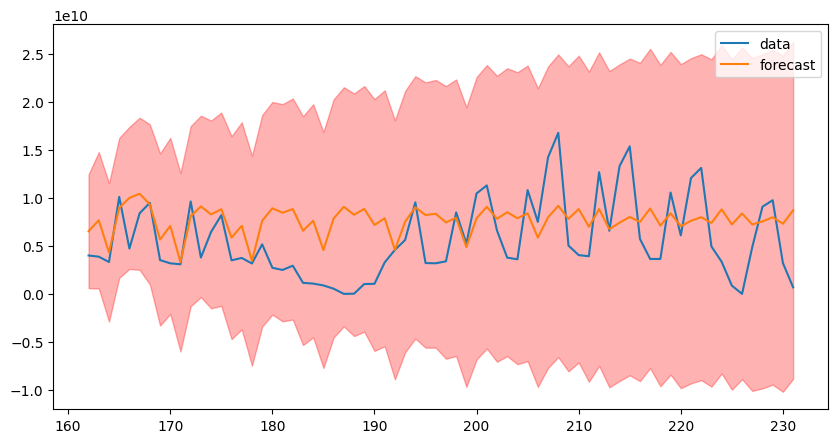

In [193]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test.index, test['total_sales'], label='data')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)
ax.legend()

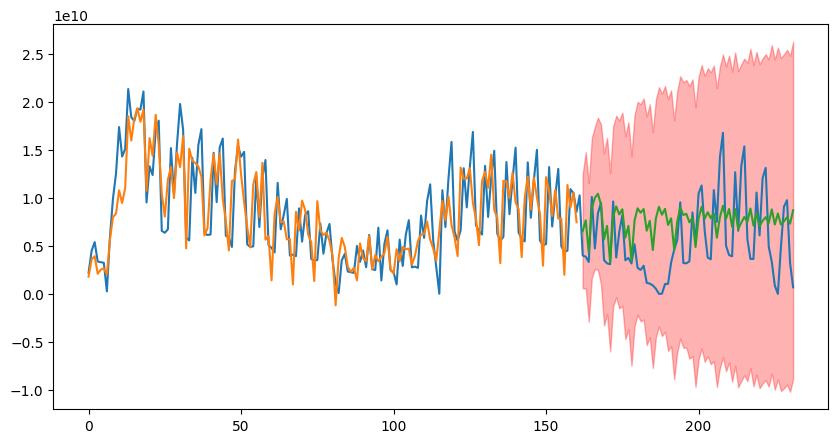

In [194]:
train = data_1.iloc[:-N_test - 1]

train_pred = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data_1.index, data_1['total_sales'], label='data')
ax.plot(train.index, train_pred, label='fitted')
ax.plot(test.index, test_pred, label='forecast')
ax.fill_between(test.index, \
                confint[:,0], confint[:,1], \
                color='red', alpha=0.3)


train = data_1.iloc[:-N_test]

In [195]:
N_test = 50
train_2 = data_2.iloc[:-N_test]
test_2 = data_2.iloc[-N_test:]
model = pm.auto_arima(train_2['total_sales'],
                      trace=True,
                      suppress_warnings=True,
                      seasonal=True, m = 52, n_jobs = 4,
                      start_p= 4, start_q = 4)



Performing stepwise search to minimize aic
 ARIMA(4,1,4)(1,0,1)[52] intercept   : AIC=5909.883, Time=6.55 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : AIC=5957.536, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : AIC=5949.720, Time=0.35 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : AIC=5939.848, Time=0.60 sec
 ARIMA(0,1,0)(0,0,0)[52]             : AIC=5955.628, Time=0.01 sec
 ARIMA(4,1,4)(0,0,1)[52] intercept   : AIC=5907.880, Time=7.05 sec
 ARIMA(4,1,4)(0,0,0)[52] intercept   : AIC=5909.510, Time=0.53 sec
 ARIMA(4,1,4)(0,0,2)[52] intercept   : AIC=5909.888, Time=39.04 sec
 ARIMA(4,1,4)(1,0,0)[52] intercept   : AIC=5908.091, Time=8.31 sec
 ARIMA(4,1,4)(1,0,2)[52] intercept   : AIC=5911.799, Time=40.99 sec
 ARIMA(3,1,4)(0,0,1)[52] intercept   : AIC=inf, Time=6.66 sec
 ARIMA(4,1,3)(0,0,1)[52] intercept   : AIC=inf, Time=5.35 sec
 ARIMA(5,1,4)(0,0,1)[52] intercept   : AIC=5906.619, Time=7.25 sec
 ARIMA(5,1,4)(0,0,0)[52] intercept   : AIC=5908.831, Time=0.61 sec
 ARIMA(5,1,4)(1,0,1)[52] in

In [201]:
N_test = 50

In [202]:
test_2_pred, confint_2 = model.predict(n_periods=N_test, return_conf_int=True)


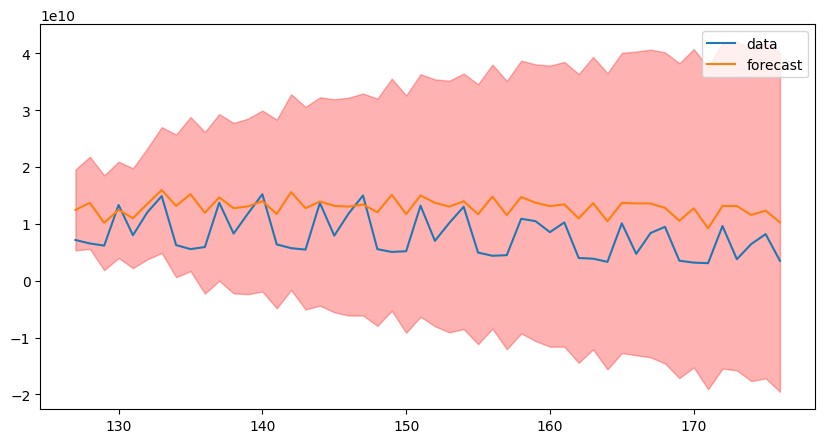

In [206]:
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(test_2.index, test_2['total_sales'], label='data')
ax.plot(test_2.index, test_2_pred, label='forecast')
ax.fill_between(test_2.index, \
                confint_2[:,0], confint_2[:,1], \
                color='red', alpha=0.3)
ax.legend()

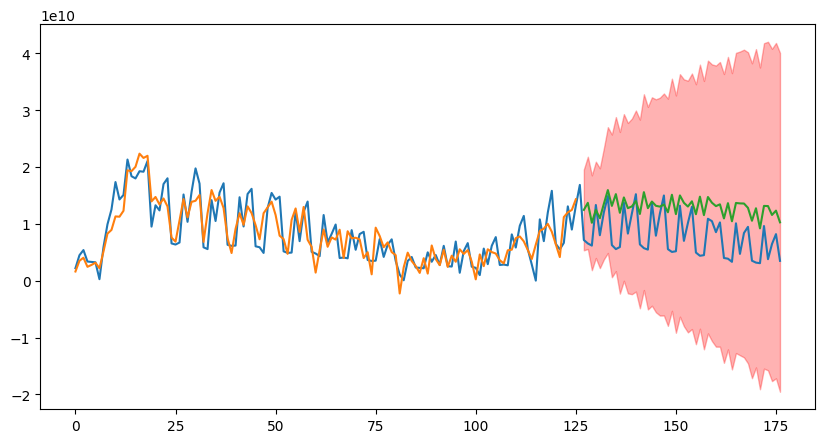

In [210]:
train_2 = data_2.iloc[:-N_test - 1]

train_2_pred = model.predict_in_sample(start=1, end=-1)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(data_2.index, data_2['total_sales'], label='data')
ax.plot(train_2.index, train_2_pred, label='fitted')
ax.plot(test_2.index, test_2_pred, label='forecast')
ax.fill_between(test_2.index, \
                confint_2[:,0], confint_2[:,1], \
                color='red', alpha=0.3)


train_2 = data_2.iloc[:-N_test]